In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)


In [2]:
df = pd.read_pickle("/Users/jenniferdimaano/Desktop/GitHub/rescue-chicago/petfinder-data/data/chicago_il_animals_cleaned.pkl")

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,id,age,gender,size,coat,name,organization_id,organization_name,published_at,status_changed_at,los,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,good_with_children,good_with_dogs,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_declawed,attribute_special_needs,attribute_shots_current,city,state
0,37845448,Young,Female,Small,Medium,Mika,IL608,Friends of Chicago Animal Care & Control,2017-04-13 22:22:16+00:00,2017-05-11 17:41:38+00:00,27,Schnauzer,Poodle,True,False,Gray / Blue / Silver,None,None,False,None,None,True,True,None,False,True,Chicago,IL
1,37868394,Young,Female,Small,Long,Luna (LuLu),IL608,Friends of Chicago Animal Care & Control,2017-04-17 21:12:27+00:00,2017-04-25 02:33:04+00:00,7,Shih Tzu,None,False,False,White / Cream,Black,None,None,None,None,True,False,None,False,True,Chicago,IL
2,37868562,Adult,Male,Small,Medium,Jack,IL608,Friends of Chicago Animal Care & Control,2017-04-17 21:44:31+00:00,2017-04-25 02:31:52+00:00,7,Maltese,Poodle,True,False,White / Cream,None,None,None,None,None,True,True,None,False,True,Chicago,IL
3,38338429,Adult,Male,Small,Short,PinPon,IL608,Friends of Chicago Animal Care & Control,2017-06-07 22:25:36+00:00,2017-08-03 17:02:39+00:00,56,Pug,None,False,False,Yellow / Tan / Blond / Fawn,None,None,False,None,None,True,True,None,False,True,Chicago,IL
4,40204215,Adult,Male,Large,Short,Uncle Jesse,IL608,Friends of Chicago Animal Care & Control,2017-12-14 19:41:06+00:00,2018-02-06 19:38:45+00:00,53,Pit Bull Terrier,None,False,False,Gray / Blue / Silver,None,None,None,None,None,True,True,None,False,True,Chicago,IL


In [5]:
# dropping irrelevant columns
df = df.drop(columns=["id", "name", "organization_id", "published_at", "status_changed_at", "attribute_declawed", "city", "state"])

In [6]:
# transform "age" column mapping age and size
age_dict={
'Baby':'0',
'Young':'1',
'Adult':'2',
'Senior':'3'
}
df['age'] = df['age'].map(age_dict).astype(str).astype(int)

In [7]:
# transform "size" column
size_dict={
'Small':'0',
'Medium':'1',
'Large': '2',
'Extra Large': '3'
}
df['size'] = df['size'].map(size_dict).astype(str).astype(int)

In [8]:
# Convert binary columns to binary (0/1) data type
binary_cols = ["breed_mixed", "breed_unknown", "good_with_children", "good_with_dogs", "good_with_cats", "attribute_spayed_neutered",
               "attribute_house_trained", "attribute_shots_current", "attribute_special_needs"]
df[binary_cols] = df[binary_cols].astype(bool).astype(int)

In [9]:
# dummy variables for gender
df['gender'] = df['gender'].replace({"Male": 0, "Female": 1})

In [10]:
# target encoding on larger categorical features
target_cols = ["coat", "organization_name", "breed_primary", "breed_secondary", "color_primary", "color_secondary", "color_tertiary"]
te = ce.TargetEncoder(cols=target_cols)
df[target_cols] = te.fit_transform(df[target_cols], df["los"])

In [11]:
df.describe()

,age,gender,size,coat,organization_name,los,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,good_with_children,good_with_dogs,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_special_needs,attribute_shots_current
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.330400,0.483600,1.040000,38.647363,36.347584,38.628400,37.758949,36.939639,0.778000,0.0,38.748927,37.883513,38.646896,0.106400,0.212800,0.05120,0.745200,0.162000,0.017600,0.752000
std,0.802928,0.499831,0.600786,3.653434,18.685068,94.438057,8.167927,4.693085,0.415674,0.0,12.557250,4.623446,0.158994,0.308411,0.409369,0.22045,0.435836,0.368525,0.131519,0.431938
min,0.000000,0.000000,0.000000,32.878956,27.682008,0.000000,29.851248,30.395413,0.000000,0.0,25.965975,34.389492,36.262176,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,35.388842,27.682008,10.000000,33.407438,35.683117,1.000000,0.0,28.527051,35.069583,38.653226,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000,40.503717,27.682008,20.000000,33.407438,35.683117,1.000000,0.0,34.941624,39.306859,38.653226,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000
75%,2.000000,1.000000,1.000000,40.503717,27.682008,40.000000,40.024498,35.683117,1.000000,0.0,40.880952,39.306859,38.653226,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,3.000000,49.614828,300.585107,2932.000000,84.407518,103.882317,1.000000,0.0,78.493800,92.352185,42.014612,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [12]:
def remove_outliers(dataframe, columns):
    for col in columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        z_scores = np.abs((dataframe[col] - mean) / std)
        dataframe = dataframe[z_scores <= 3]
    return dataframe

# Remove outliers from Carats, Price, and Retail using Z-score
df = remove_outliers(df, ['organization_name', 'los', 'breed_primary', 'breed_secondary'])

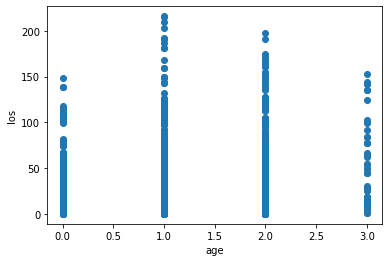

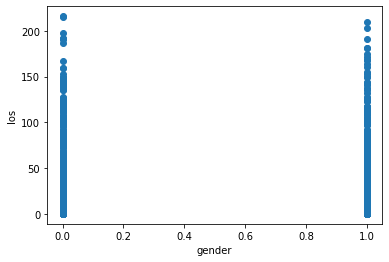

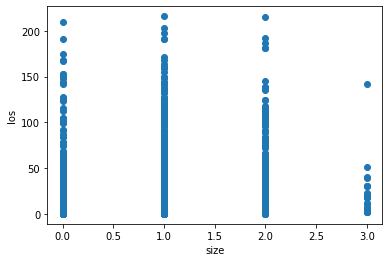

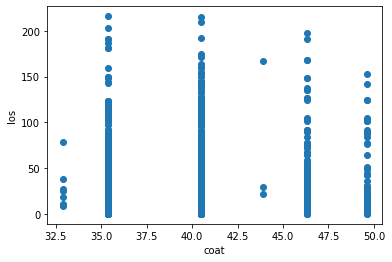

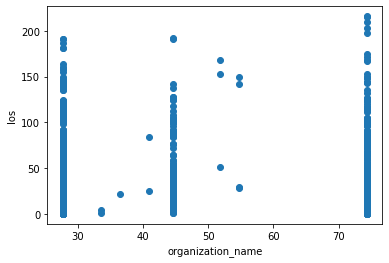

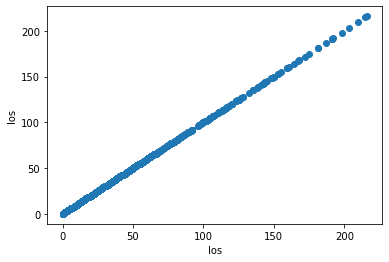

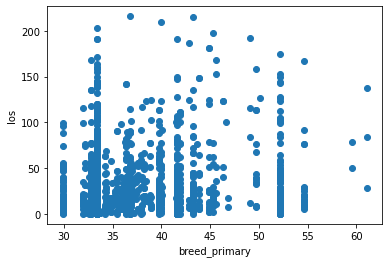

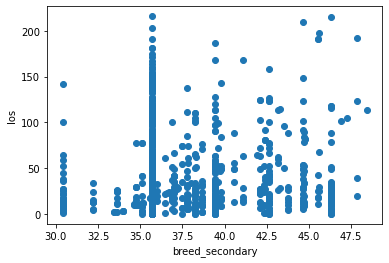

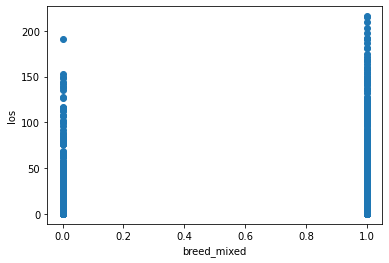

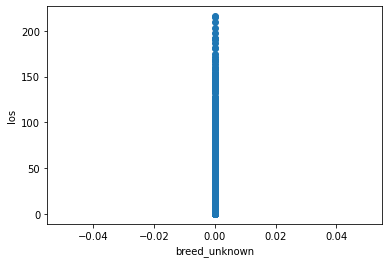

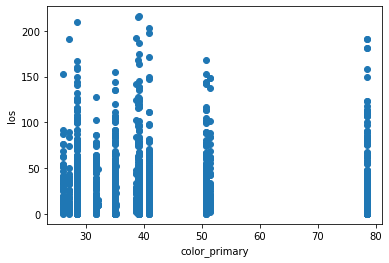

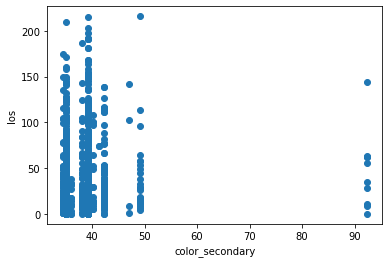

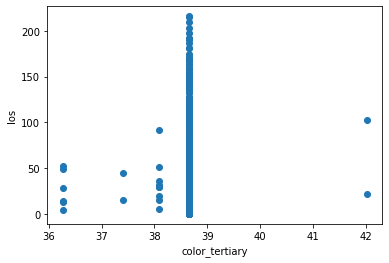

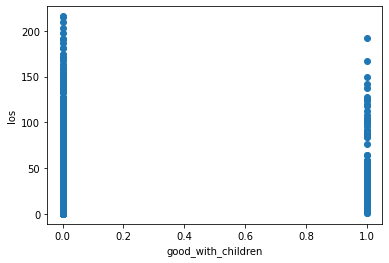

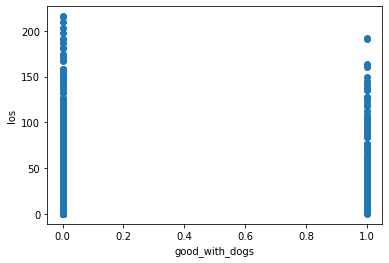

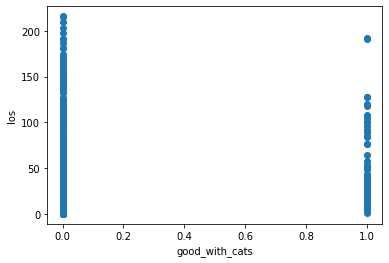

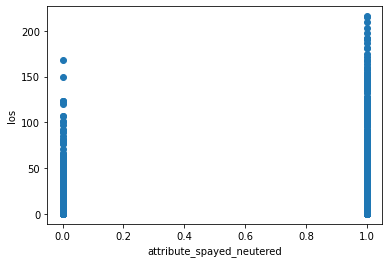

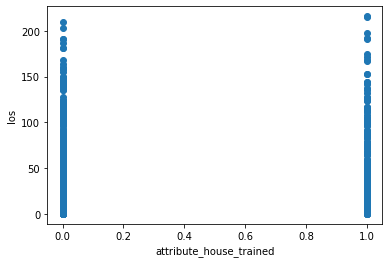

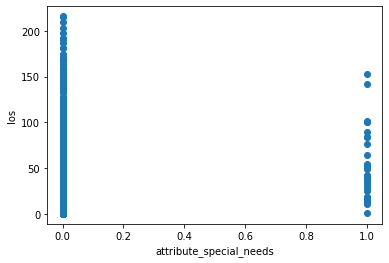

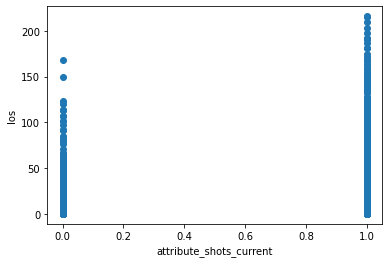

In [13]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()


# Create a scatter plot of numeric features against "los"
for col in num_cols:
    plt.scatter(df[col], df["los"])
    plt.xlabel(col)
    plt.ylabel("los")
    plt.show()


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

In [16]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', np.mean(mae))
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', np.mean(r2))

Mean squared error: 0.04472731799941284
Mean Absolute Error: 0.11020506769894398
R^2 Score: 0.7617882843070173
